In [1]:
import cv2
import numpy as np
import onnxruntime as rt
import matplotlib.pyplot as plt

In [2]:
class AI:
    def __init__(self, model_path: str):
        self.sess = rt.InferenceSession(model_path, providers=[
            'TensorrtExecutionProvider', 'CUDAExecutionProvider', 'CPUExecutionProvider'])

        self.input_name = self.sess.get_inputs()[0].name
        self.output_name = self.sess.get_outputs()[0].name
        self.mean = np.array([0.485, 0.456, 0.406], dtype=np.float32)
        self.std = np.array([0.229, 0.224, 0.225], dtype=np.float32)

    def preprocess(self, img: np.ndarray) -> np.ndarray:
        img = cv2.resize(img, (224, 224))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = img.astype(np.float32) / 255.0
        img = (img - self.mean) / self.std
        img = np.transpose(img, (2, 0, 1))  # HWC -> CHW
        img = np.expand_dims(img, axis=0)  # Add batch dim
        return img.astype(np.float32)

    def postprocess_all_regression(self, detections: np.ndarray) -> np.ndarray:
        detections = np.squeeze(detections)
        return detections.astype(np.float32)
    
    def postprocess_regression_class(self, detections: np.ndarray) -> tuple:
        detections = np.squeeze(detections)  # shape: (4,)
        forward = float(detections[0])

        left_logits = detections[1:]
        left_class = int(np.argmax(left_logits))  # 0, 1, or 2

        # Optional: map class index to direction
        class_to_direction = { 0: -1, 1: 0, 2: 1}
        left = class_to_direction[left_class]

        return forward, left
    
    def postprocess_regression_class_5(self, detections: np.ndarray) -> tuple:
        detections = np.squeeze(detections)  # shape: (4,)
        forward = float(detections[0])

        left_logits = detections[1:]
        left_class = int(np.argmax(left_logits))  # 0, 1, or 2
        print(left_logits)
        print(left_class)

        # Optional: map class index to direction
        class_to_direction = { 0: -1, 1: -0.5, 2: 0, 3: 0.5, 4:1}
        left = class_to_direction[left_class]

        return forward, left

    def predict_all_regression(self, img: np.ndarray) -> np.ndarray:
        inputs = self.preprocess(img)
        detections = self.sess.run([self.output_name], {self.input_name: inputs})[0]
        return self.postprocess_all_regression(detections)
    
    def predict_regression_class(self, img: np.ndarray) -> np.ndarray:
        inputs = self.preprocess(img)
        detections = self.sess.run([self.output_name], {self.input_name: inputs})[0]
        return self.postprocess_regression_class(detections)
    
    def predict_regression_class_5(self, img: np.ndarray) -> np.ndarray:
        inputs = self.preprocess(img)
        detections = self.sess.run([self.output_name], {self.input_name: inputs})[0]
        return self.postprocess_regression_class_5(detections)


def check(img_name):
    image_path = f'camera/{img_name}.png'
    image = cv2.imread(image_path)
    if image is None:
        raise FileNotFoundError(f"Image '{image_path}' not found!")

    model_path = 'model_jetbot3.onnx'
    ai = AI(model_path)
    """
    - ai.predict_all_regression()
    - ai.predict_regression_class()
    """

    prediction = ai.predict_regression_class_5(image)

    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image_rgb)
    plt.axis('off')
    plt.title(f"Prediction: forward={prediction[0]:.3f}, left={prediction[1]:.3f}")
    plt.show()

    print(f'Prediction: forward={prediction[0]:.4f}, left={prediction[1]:.4f}')


In [3]:
# import numpy as np

# def show_preprocessed_image(preprocessed_img):
#     # preprocessed_img ma shape (1, 3, 224, 224)
#     img = preprocessed_img[0]  # usuń batch dimension -> (3, 224, 224)
    
#     # Transpozycja z powrotem do (224, 224, 3)
#     img = np.transpose(img, (1, 2, 0))
    
#     # Odwróć normalizację (zakładając, że normalizacja była:
#     # mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
#     mean = np.array([0.485, 0.456, 0.406])
#     std = np.array([0.229, 0.224, 0.225])
    
#     img = (img * std) + mean
    
#     # Obcięcie wartości do zakresu [0,1]
#     img = np.clip(img, 0, 1)
    
#     plt.imshow(img)
#     plt.title("Obraz po preprocessingu")
#     plt.axis('off')
#     plt.show()


# # 1. Wczytaj oryginalny obraz i wyświetl
# image = cv2.imread('camera/0029.png')
# image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# plt.imshow(image_rgb)
# plt.title("Oryginalny obraz")
# plt.axis('off')
# plt.show()

# # 2. Zrób preprocess
# def preprocess(img):
#     img = cv2.resize(img, (224, 224))
#     img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#     img = img.astype(np.float32) / 255.0
#     img = np.transpose(img, (2, 0, 1))
#     img = np.expand_dims(img, axis=0)
#     return img

# preprocessed_img = preprocess(image)

# # 3. Wyświetl obraz po preprocessingu (odwróć transformacje)
# show_preprocessed_image(preprocessed_img)



[ 2.6621528 -1.506426   1.9495989 -2.4073205  1.5230862]
0


c:\Users\joasi\AppData\Local\Programs\Python\Python312\Lib\site-packages\onnxruntime\capi\onnxruntime_inference_collection.py:121: UserWarning: Specified provider 'TensorrtExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(
c:\Users\joasi\AppData\Local\Programs\Python\Python312\Lib\site-packages\onnxruntime\capi\onnxruntime_inference_collection.py:121: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


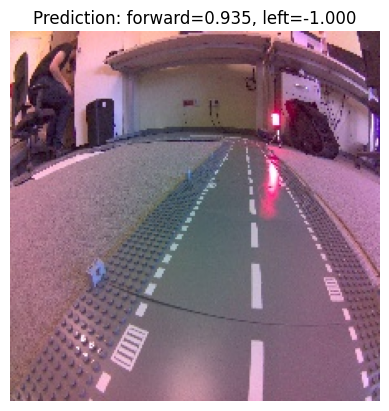

Prediction: forward=0.9355, left=-1.0000


In [4]:
check("0016")

[ 2.806834  -1.1141874  4.778153  -1.7365952  3.4520674]
2


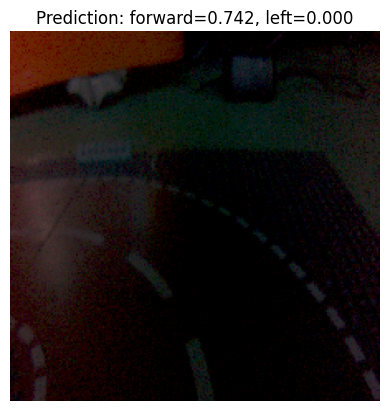

Prediction: forward=0.7416, left=0.0000


In [5]:
check("1")

[ 1.9595068 -0.7540703  3.247097  -1.2281766  2.2479553]
2


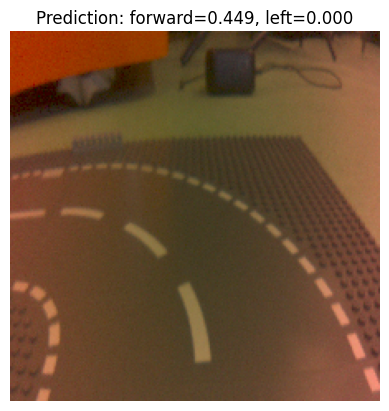

Prediction: forward=0.4488, left=0.0000


In [6]:
check(2)

[ 2.121448  -0.7842596  3.506648  -1.2758406  2.2964928]
2


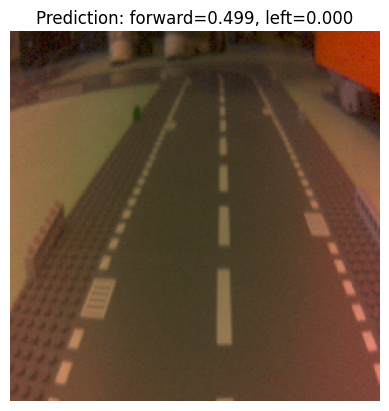

Prediction: forward=0.4987, left=0.0000


In [7]:
check(3)

[ 1.8285623 -0.6816382  2.964508  -1.1341391  1.9524972]


2


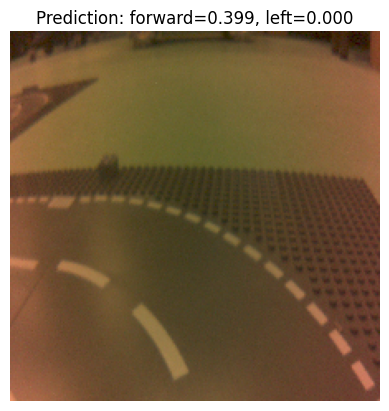

Prediction: forward=0.3989, left=0.0000


In [8]:
check(4)

[ 3.909516   -0.29928103  6.217979   -1.1125672   2.1874647 ]
2


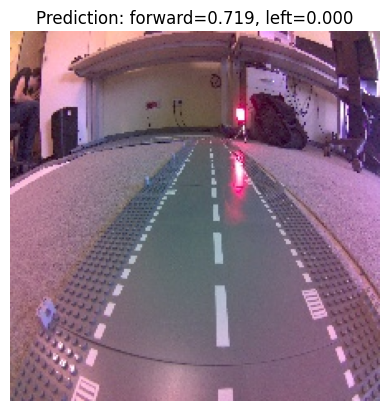

Prediction: forward=0.7185, left=0.0000


In [9]:
check("0029")